# open-closed eye detection

In [38]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import load_model



example

In [25]:
pic=plt.imread("train\Open_Eyes\s0001_02334_0_0_1_0_0_01.png")


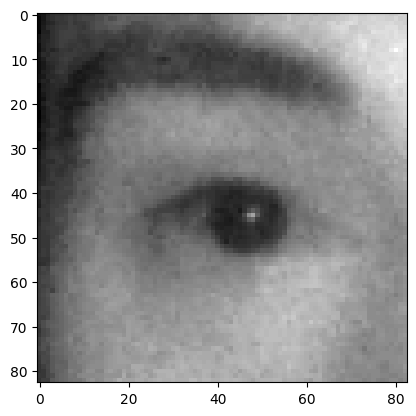

In [26]:
plt.imshow(pic, cmap="gray")

In [27]:
pic.shape

(83, 83)

In [28]:
Datadirectory = 'train'
Classes = ['Closed_Eyes', 'Open_Eyes']
img_size = 100

# Preprocessing and preparation of the data


In [29]:
def apply_data_augmentation(img):
    # Randomly flip the image horizontally
    if random.random() > 0.5:
        img = cv2.flip(img, 1)

    # Randomly flip the image vertically
    if random.random() > 0.5:
        img = cv2.flip(img, 0)

    # Randomly rotate the image by an angle between -15 and 15 degrees
    angle = random.uniform(-15, 15)
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv2.warpAffine(img, M, (cols, rows))

    # Randomly shift the image horizontally and vertically by up to 10% of the image size
    shift_x = random.randint(-int(0.1 * cols), int(0.1 * cols))
    shift_y = random.randint(-int(0.1 * rows), int(0.1 * rows))
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    img = cv2.warpAffine(img, M, (cols, rows))

    return img

In [30]:

def create_training_data(Classes, Datadirectory, img_size):
    training_data = []
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)

            # Resize the image while maintaining the aspect ratio
            desired_size = (img_size, img_size)
            height, width = img_array.shape
            aspect_ratio = width / height

            if aspect_ratio >= 1:
                new_width = desired_size[0]
                new_height = int(new_width / aspect_ratio)
            else:
                new_height = desired_size[1]
                new_width = int(new_height * aspect_ratio)

            resized_image = cv2.resize(img_array, (new_width, new_height))

            # Pad the resized image to make it square (img_size x img_size)
            pad_width = (desired_size[1] - new_height) // 2
            pad_height = (desired_size[0] - new_width) // 2
            padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

            # Normalize the pixel values to [0, 1] using Minmax normalization
            normalized_image = padded_image / 255.0

            # Convert the grayscale image to RGB
            rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
            
            #perform data_augmentation
            #rgb_image = apply_data_augmentation(rgb_image)
            training_data.append([rgb_image, class_num])

    print("Data processing completed.")
    return training_data

In [31]:
training_data = create_training_data(Classes, Datadirectory, img_size)
#C:\Users\ahmed\Desktop\Supcom\stage ingenieur\distraction_detector\STAGE\PART_2

Data processing completed.


# Shuffle and reshape the data

In [32]:
random.shuffle(training_data)

In [33]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
Y=np.array(y)

# Building the model

In [39]:
# Define the input shape
input_shape = (100, 100, 3)
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output from Conv2D layers
model.add(layers.Flatten())

# Add fully connected layers with specified parameters
model.add(layers.Dense(16384, activation='relu'))
model.add(layers.Dense(180, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [40]:
# Print the summary of the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 94, 94, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 47, 47, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 22, 22, 256)       0         
 ng2D)                                                

In [41]:
#model.save('my_model.keras')


In [42]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, mode='max', verbose=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

# Train the model with EarlyStopping callback
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping_callback])



Epoch 1/20
  4/100 [>.............................] - ETA: 15:02 - loss: 13.4107 - accuracy: 0.5625

KeyboardInterrupt: 

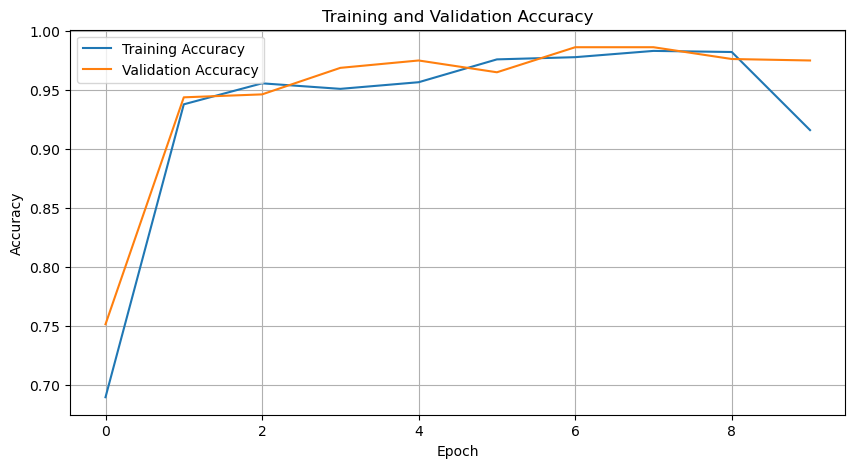

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

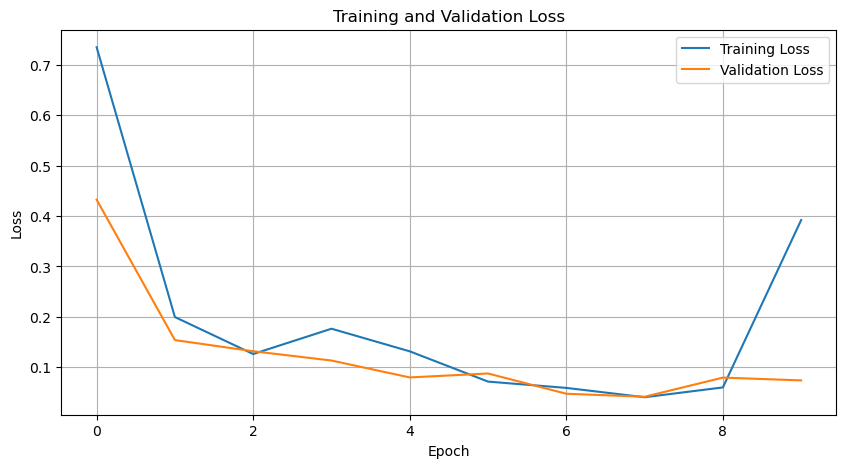

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Make predicitons

In [ ]:
import cv2
import numpy as np

def preprocess_single_image(image_path, img_size):
    # Read the image in grayscale
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image while maintaining the aspect ratio
    desired_size = (img_size, img_size)
    height, width = img_array.shape
    aspect_ratio = width / height

    if aspect_ratio >= 1:
        new_width = desired_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = desired_size[1]
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(img_array, (new_width, new_height))

    # Pad the resized image to make it square (img_size x img_size)
    pad_width = (desired_size[1] - new_height) // 2
    pad_height = (desired_size[0] - new_width) // 2
    padded_image = np.pad(resized_image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    # Normalize the pixel values to [0, 1] using Minmax normalization
    normalized_image = padded_image / 255.0

    # Convert the grayscale image to RGB
    rgb_image = cv2.cvtColor(padded_image, cv2.COLOR_GRAY2RGB)
    #rgb_image = apply_data_augmentation(rgb_image)
    return rgb_image


In [ ]:
image_path = "/kaggle/input/openclosed/Screenshot 2023-08-02 094721.png"
tttt=plt.imread(image_path)
print(tttt.shape)
preprocessed_image = preprocess_single_image(image_path, img_size)
print(preprocessed_image.shape)
resized_image = cv2.resize(preprocessed_image, (100, 100))
# Reshape the preprocessed image to match the input shape of the model
preprocessed_image = resized_image.reshape(-1, img_size, img_size, 3)

# Make predictions using the model
predictions = model.predict(preprocessed_image)
print(predictions)
# The 'predictions' variable will contain the probability of the image belonging to each class.
# You can use 'np.argmax(predictions)' to get the predicted class index with the highest probability.


(102, 146, 4)
(99, 100, 3)
1/1 [==============================] - 0s 20ms/step
[[3.6597388e-07]]
